# CityB Support Vectoer Regression  
- 線形補間を導入
- 特徴量の付与
- SVRによる人流予測

#### Setting

In [1]:
# BLEUのインストール
!git clone https://github.com/yahoojapan/geobleu.git
!pip install geobleu/

Cloning into 'geobleu'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 180 (delta 18), reused 21 (delta 13), pack-reused 150 (from 1)
Receiving objects: 100% (180/180), 31.57 KiB | 1.26 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Processing ./geobleu
  Preparing metadata (setup.py) ... done
  Created wheel for geobleu: filename=geobleu-0.4-py3-none-any.whl size=5012 sha256=e0ec7d36b12579e51d86166ce8b46da2018af8287f0c7ebf209245c1b1dcd854
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdsohk1c/wheels/ed/6c/56/e94f375b59f93c834a4057ea971e162edd31b957950c633e45
Successfully built geobleu
  Attempting uninstall: geobleu
    Found existing installation: geobleu 0.3
    Uninstalling geobleu-0.3:
      Successfully uninstalled geobleu-0.3


In [1]:
import pandas as pd
import numpy as np
import geobleu
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Parameter

In [2]:
city = "C"
#CityA
# user_id_start = 144001
# user_id_end = 147001

# CityC
user_id_start = 19001
user_id_end = 22000

# CityD
# user_id_start = 14001
# user_id_end = 17000

# 分割する日付
day_split = 60

#### Path

In [3]:
ls ../../data_2025/

city_A_challengedata_interpolated_n24.csv
city_A_challengedata_interpolated_n24_valid.csv
city_A_valid.csv
city_B_challengedata_interpolated_n24.csv
city_B_valid.csv
city_C_challengedata_interpolated_n24.csv
city_C_valid.csv
city_D_challengedata_interpolated_n24.csv
city_D_valid.csv


In [4]:
# BASE_PATH = "../../../s3storage/01_public/humob-challenge-2025/middle_mart/exp001/"
BASE_PATH = "../../data_2025/"
DATA_PATH = f"city_{city}_challengedata_interpolated_n24.csv"
TARGET_USER_PATH = f"city_{city}_valid.csv"
INPUT_PATH = BASE_PATH + DATA_PATH
INPUT_USER_PATH = BASE_PATH + TARGET_USER_PATH

In [5]:
INPUT_PATH

'../../data_2025/city_C_challengedata_interpolated_n24.csv'

In [6]:
INPUT_USER_PATH

'../../data_2025/city_C_valid.csv'

#### Read data

In [7]:
df_city_b = pd.read_csv(INPUT_PATH)
df_city_b.head(3)

,uid,d,t,x,y
0,1,1,12,97,152
1,1,1,13,99,150
2,1,1,14,101,148


In [12]:
valid_user_list = pd.read_csv(INPUT_USER_PATH)["uid"].unique()
valid_user_list
print(len(valid_user_list))

3000


#### Filter users and Split the data into training data and ground truth data around d=60.

In [9]:
df_city_b_valid = df_city_b[df_city_b['uid'].isin(valid_user_list)]
df_city_b_valid.head()

,uid,d,t,x,y
31692,14,1,28,110,149
31693,14,1,29,109,149
31694,14,1,30,109,149
31695,14,1,31,110,149
31696,14,1,32,109,150


In [10]:
# # 対象のuidのデータを検証に利用
# df_city_b_valid = (
#     df_city_b
#     .loc[df_city_b["uid"].between(user_id_start, user_id_end)]
# )
# df_city_b_valid.head(3)

In [11]:
# dが60前後でデータを分割
df_city_b_train = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] <= day_split]
)
df_city_b_answer = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] > day_split]
)

#### Create features

In [13]:
def attach_feature_data_and_time(df):
    df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
    df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
    df["date_ant_time_alpha_t"] = np.sin(2 * np.pi/24 * df["t"])
    df["date_ant_time_beta_t"] = np.cos(2 * np.pi/24 * df["t"])
    return df

In [14]:
def attach_feature_activity_time(df):
    # act の定義: 18 ≤ t < 23 または 33 ≤ t < 38
    df['act'] = np.where(((df['t'] >= 18) & (df['t'] < 23)) | ((df['t'] >= 33) & (df['t'] < 38)), 1, 0)

    # high_act の定義: 23 ≤ t < 33
    df['high_act'] = np.where((df['t'] >= 23) & (df['t'] < 33), 1, 0)

    # rest の定義: 13 ≤ t < 18 または 38 ≤ t < 44
    df['rest'] = np.where(((df['t'] >= 13) & (df['t'] < 18)) | ((df['t'] >= 38) & (df['t'] < 44)), 1, 0)

    # deep_rest の定義: 0 ≤ t < 13 または 44 ≤ t < 48
    df['deep_rest'] = np.where(((df['t'] >= 0) & (df['t'] < 13)) | ((df['t'] >= 44) & (df['t'] < 48)), 1, 0)

    return df

In [15]:
def attach_feature_day_of_week(df, city):
    """
    都市ごとに異なる曜日付与ロジックを適用する関数
    
    Parameters:
    df: DataFrame with 'd' column
    city: str, 'CityA', 'CityB', 'CityC', or 'CityD'
    
    Returns:
    DataFrame with 'dow' column added (0:Mon, 1:Tue, ..., 6:Sun)
    """
    
    if city in ['CityA', 'CityB']:
        # CityA, CityBは全期間で日時が分かる場合
        df["date"] = pd.to_datetime("2022-08-20") + pd.to_timedelta(df["d"], unit="D")
        df["dow"] = df["date"].dt.weekday
        return df.drop(columns=["date"])
    
    elif city in ['CityC', 'CityD']:
        # CityC, CityDは60~75で曜日のみ分かる場合
        
        # d < 60の場合は通常の日付計算
        mask_before_60 = df["d"] < 60
        df.loc[mask_before_60, "date"] = pd.to_datetime("2022-08-20") + pd.to_timedelta(df.loc[mask_before_60, "d"], unit="D")
        df.loc[mask_before_60, "dow"] = df.loc[mask_before_60, "date"].dt.weekday
        
        # d >= 60の場合は曜日情報から計算
        # d=61が月曜日(0)なので、d=60は日曜日(6)
        mask_after_60 = df["d"] >= 60
        df.loc[mask_after_60, "dow"] = (df.loc[mask_after_60, "d"] - 60 + 6) % 7
        
        # 一時的なdate列を削除
        if "date" in df.columns:
            df = df.drop(columns=["date"])

        return df
    
    else:
        raise ValueError(f"Unknown city: {city}")


In [16]:
def attach_feature_weekday_holiday(df):
    df['weekdays'] = df['dow'].apply(lambda x: 0 if x in [5, 6] else 1)

    return df

In [17]:
def attach_feature_am_pm(df):
    # AM フラグを設定: 0 ≤ t < 25 は 1、それ以外は 0
    df['AM'] = np.where((df['t'] >= 0) & (df['t'] < 25), 1, 0)
    
    # # PM フラグを設定: AM が 0 の場合は PM は 1、AM が 1 の場合は PM は 0
    # df['PM'] = np.where(df['AM'] == 1, 0, 1)
    return df

In [18]:
# ユークリッド距離を計算する関数
def calc_euclidean_distance(row1, row2):
    return np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)

# 移動角度を計算する関数
def calc_angle(row1, row2):
    delta_x = row2['x'] - row1['x']
    delta_y = row2['y'] - row1['y']
    angle = np.arctan2(delta_y, delta_x)
    return np.degrees(angle) % 360

# 各特徴量ごとに移動系の特徴量を計算して付与する関数
def attach_movement_features_by_columns(df, group_columns):
    for col in group_columns:
        print(f"Processing for {col}...")  # 処理の進捗を表示
        
        result_list = []

        # 各特徴量でグループ化して処理を実行（進捗をtqdmで表示）
        for values, group in tqdm(df.groupby(['uid', col]), desc=f"Processing {col}"):
            group = group.sort_values(by=['d', 't'])  # 時間ベースでソート

            euclidean_distances = []
            angles = []

            # 移動距離と角度を計算
            for i in range(1, len(group)):
                dist_euc = calc_euclidean_distance(group.iloc[i-1], group.iloc[i])
                angle = calc_angle(group.iloc[i-1], group.iloc[i])
                euclidean_distances.append(dist_euc)
                angles.append(angle)

            move_count = len(euclidean_distances)

            # 移動距離の平均、標準偏差、移動角度の平均を計算
            if move_count > 0:
                avg_euclidean_distance = np.mean(euclidean_distances)
                std_euclidean_distance = np.std(euclidean_distances)
                avg_angle = np.mean(angles)
            else:
                avg_euclidean_distance = 0
                std_euclidean_distance = 0
                avg_angle = 0

            # グループ化された値ごとの結果を保存
            result_dict = {
                'uid': values[0],
                col: values[1],
                f'move_count_{col}': move_count,
                f'avg_euclidean_distance_{col}': avg_euclidean_distance,
                f'std_euclidean_distance_{col}': std_euclidean_distance,
                f'avg_angle_{col}': avg_angle
            }
            result_list.append(result_dict)

        # 結果をデータフレームに変換してマージ
        result_df = pd.DataFrame(result_list)
        df = pd.merge(df, result_df, on=['uid', col], how='left')
    
    return df

In [19]:
def attach_features_about_date_and_time(df):
    df = attach_feature_data_and_time(df)
    df = attach_feature_activity_time(df)
    df = attach_feature_day_of_week(df,f"City{city}")
    df = attach_feature_weekday_holiday(df)
    df = attach_feature_am_pm(df) 

    return df

In [20]:
# 時刻系の特徴量の付与
df_city_b_train_ip = attach_features_about_date_and_time(df_city_b_train)

/tmp/ipykernel_19750/2592063384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
/tmp/ipykernel_19750/2592063384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
/tmp/ipykernel_19750/2592063384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [21]:
# # 移動系の特徴量の付与
# group_columns = ['act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM']
# df_city_b_train_ip = attach_movement_features_by_columns(df_city_b_train_ip, group_columns)

In [22]:
## Example
df_city_b_train_ip[(df_city_b_train_ip["uid"] == user_id_start)&(df_city_b_train_ip["weekdays"] == 0)].head(5)

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,high_act,rest,deep_rest,dow,weekdays,AM


### Train and Predict

In [23]:
# ユーザーごと（uidごと）にデータを分けてモデルを作成
uids = df_city_b_train_ip['uid'].unique()

# 各uidごとにモデルを作成し、結果を格納する辞書
models = {}
future_predictions = []

for uid in tqdm(uids,desc="Processing uids"):

    # 該当uidのデータを抽出
    user_data = df_city_b_train_ip[df_city_b_train_ip['uid'] == uid]
    # 学習に必要ないカラムは除去
    user_data_train = user_data.drop(columns=["uid","d","t","x","y"])

    #目的変数の設定
    y_train_x = user_data['x']
    y_train_y = user_data['y']

    # データの標準化
    scaler = StandardScaler()
    user_data_train_scaled = scaler.fit_transform(user_data_train)

    # SVR モデルの作成と学習 (xとyそれぞれのモデル)
    svr_x = SVR(kernel='rbf')
    svr_x.fit(user_data_train_scaled, y_train_x)

    svr_y = SVR(kernel='rbf')
    svr_y.fit(user_data_train_scaled, y_train_y) 

    # モデルの保存
    models[(uid, 'x')] = svr_x
    models[(uid, 'y')] = svr_y

    # 未来の予測
    # 予測期間の設定 (d=61からd=75まで)
    d_range = np.arange(61, 76)  # 61～75のd値
    time_range = np.arange(0, 48)  # t=0～47の範囲 (30分ごと)

    # d と t の組み合わせを生成
    future_dates = pd.DataFrame([(d, t) for d in d_range for t in time_range], columns=['d', 't'])
    
    # dとtだけで決まる特徴量を作成
    future_dates_featured = attach_features_about_date_and_time(future_dates)
    future_dates_featured = future_dates_featured.drop(columns=["d","t"])

    #  # 未来のデータに対して特徴量を付与する関数
    # def attach_future_movement_features(df, user_data, group_columns):
    #     for col in group_columns:
    #         # 特定の値に基づいて特徴量を付与
    #         for feature in [f'move_count_{col}', f'avg_euclidean_distance_{col}', 
    #                         f'std_euclidean_distance_{col}', f'avg_angle_{col}']:
    #             feature_values = user_data.groupby(col)[feature].last().reset_index()

    #             # 未来データに過去の特徴量を付与
    #             df = pd.merge(df, feature_values, on=col, how='left')

    #     return df
        
    # group_columns = ['act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM']
    # future_dates_featured = attach_future_movement_features(future_dates_featured, user_data,group_columns)
    # future_dates_featured.fillna(future_dates_featured.mean(), inplace=True)
    
    # 標準化
    future_df_scaled = scaler.transform(future_dates_featured)

    #学習したモデルで未来予測
    y_pred_x = svr_x.predict(future_df_scaled)
    y_pred_y = svr_y.predict(future_df_scaled)
    
    
    # 予測データを整形
    future_dates['uid'] = uid
    future_dates['x'] = y_pred_x
    future_dates['y'] = y_pred_y
    future_predictions.append(future_dates)


# uidをすべて結合
future_predictions_df = pd.concat(future_predictions, ignore_index=True)
future_predictions_df["x"] = future_predictions_df["x"].round(0)
future_predictions_df["y"] = future_predictions_df["y"].round(0)

Processing uids:   0%|          | 0/3000 [00:00<?, ?it/s]

Processing uids: 100%|██████████| 3000/3000 [17:19<00:00,  2.89it/s]


#### Calculate metrics

In [24]:
### 正解データと予測データ 組み合わせ
combined_data = (
    pd.merge(
        df_city_b_answer,
        future_predictions_df.rename(columns = {"x":"x_pred","y":"y_pred"}),
        on = ["uid","d","t"],
        how = "left"
    )
)[["uid","d","t","x","y","x_pred","y_pred"]]


In [25]:
# combined_data_tmp = combined_data[combined_data["d"] != 75]

In [26]:
uids = df_city_b_train_ip['uid'].unique()

In [27]:
list_geobleu_val = []
list_dtw_val = []

# for i in tqdm(range(user_id_start, user_id_end),desc="Processing uids"):
for i in tqdm(uids,desc="Processing uids"):


    # 該当uidのデータを抽出
    # df = (
    #     combined_data
    #     .loc[combined_data["uid"] == i]
    # )

    df = (
        combined_data
        .loc[combined_data["uid"] == i]
    )

    # 予測値のリスト
    df_pred = df[["d", "t", "x_pred", "y_pred"]]
    list_pred = [tuple(row) for row in df_pred.to_records(index=False)]

    # 正解値のリスト
    df_answer = df[["d", "t", "x", "y"]]
    list_answer = [tuple(row) for row in df_answer.to_records(index=False)]

    # スコア算出
    geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    list_geobleu_val.append(geobleu_val)
    
    dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    list_dtw_val.append(dtw_val)


Processing uids: 100%|██████████| 3000/3000 [13:35<00:00,  3.68it/s]


#### Result

In [28]:
list_geobleu_val

[0.058068671927476403,
 0.0005852394134140837,
 0.0843628999052309,
 0.015008176255704254,
 9.923050852516273e-11,
 4.150969289839143e-05,
 0.022259764699578768,
 3.514376232494375e-05,
 6.60788750697043e-05,
 0.00012278369118971295,
 6.42573349553549e-05,
 0.2988811377903087,
 0.03178093916878464,
 0.04710855521785329,
 0.017874151383756687,
 0.10239653590074102,
 0.001621138523767368,
 0.005403212367810676,
 0.023398985146275024,
 0.01013614128613602,
 0.008498589017637363,
 0.22036200822724625,
 0.10491491210680491,
 0.0005086024731586683,
 0.03872396600477175,
 2.1032951200084993e-08,
 0.0017422163258078653,
 0.00509803639138746,
 0.013418003289475993,
 7.359309981360147e-05,
 0.03346135644784651,
 0.013162403487086768,
 0.002220858987274897,
 0.0002442984550836292,
 0.0008945225537063176,
 0.020817245138951623,
 0.0011424710382793627,
 0.025805452395466104,
 0.04091370127127769,
 0.09126983137591632,
 0.045506375268978654,
 0.002655949961707855,
 2.5306522011616587e-06,
 0.0023150

In [29]:
print(f"geobleu:{np.mean(list_geobleu_val)}")
print(f"dtw:{np.mean(list_dtw_val)}")

geobleu:0.04542075515202085
dtw:56.3294715190893


#### Check & Visualize

(array([2.29e+03, 3.41e+02, 1.35e+02, 6.90e+01, 4.70e+01, 3.30e+01,
        2.80e+01, 1.80e+01, 8.00e+00, 7.00e+00, 7.00e+00, 1.00e+00,
        6.00e+00, 4.00e+00, 2.00e+00, 1.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 2.00e+00]),
 array([1.1959434e-57, 5.0000000e-02, 1.0000000e-01, 1.5000000e-01,
        2.0000000e-01, 2.5000000e-01, 3.0000000e-01, 3.5000000e-01,
        4.0000000e-01, 4.5000000e-01, 5.0000000e-01, 5.5000000e-01,
        6.0000000e-01, 6.5000000e-01, 7.0000000e-01, 7.5000000e-01,
        8.0000000e-01, 8.5000000e-01, 9.0000000e-01, 9.5000000e-01,
        1.0000000e+00]),
 <BarContainer object of 20 artists>)

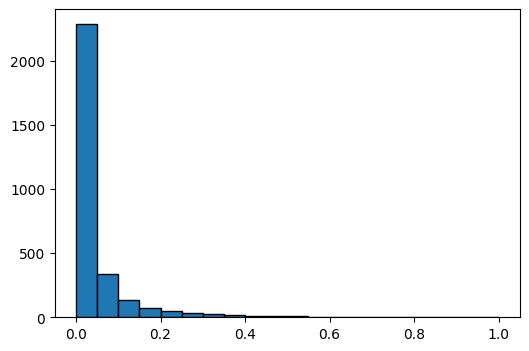

In [31]:
plt.figure(figsize=(6, 4))
plt.hist(list_geobleu_val, bins=20, edgecolor='black')

(array([1.349e+03, 3.940e+02, 1.410e+02, 5.300e+01, 3.000e+01, 1.500e+01,
        5.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.        ,  24.10516898,  48.21033796,  72.31550694,
         96.42067592, 120.5258449 , 144.63101388, 168.73618285,
        192.84135183, 216.94652081, 241.05168979, 265.15685877,
        289.26202775, 313.36719673, 337.47236571, 361.57753469,
        385.68270367, 409.78787265, 433.89304163, 457.9982106 ,
        482.10337958]),
 <BarContainer object of 20 artists>)

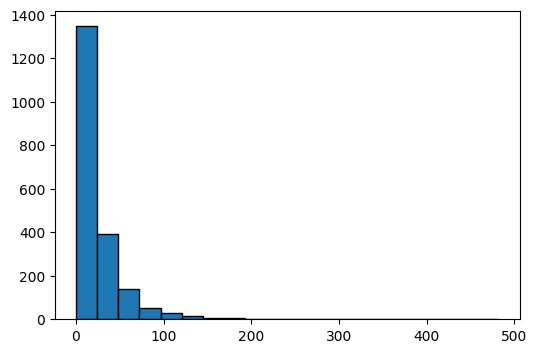

In [68]:
plt.figure(figsize=(6, 4))
plt.hist(list_dtw_val, bins=20, edgecolor='black')

#### Visuaize Specified Uid's Trajectory

In [69]:
uid = 20308

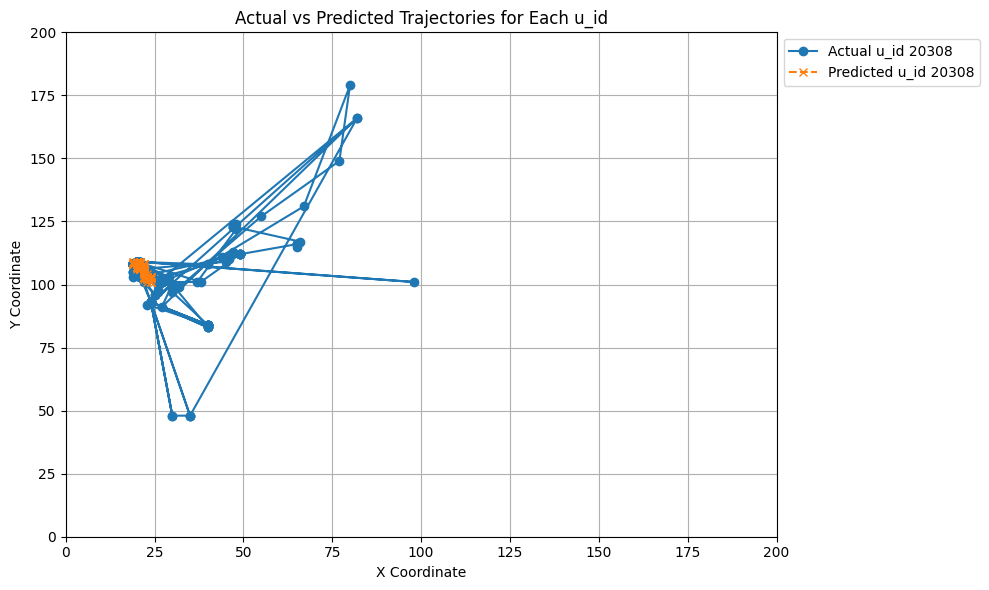

In [70]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 200)  # x軸の範囲を設定
plt.ylim(0, 200)  # y軸の範囲を設定

# プロットを表示
plt.tight_layout()
plt.show()

In [117]:
uid = 21459

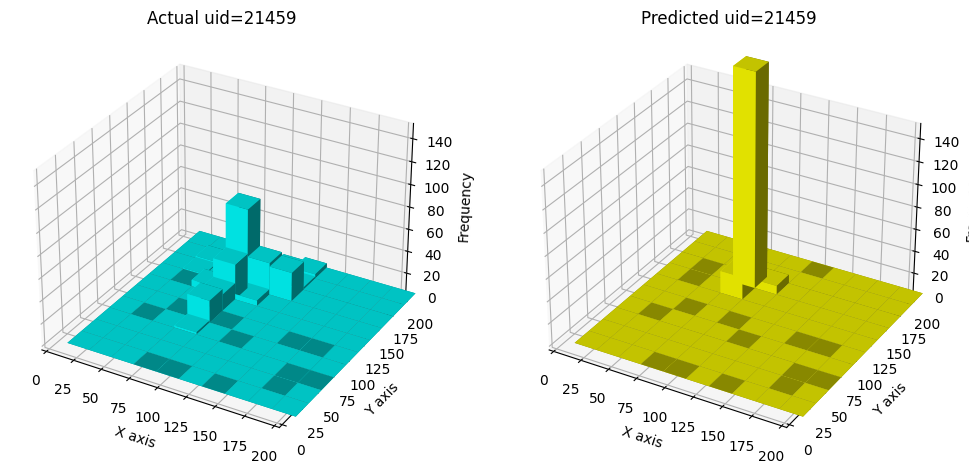

In [119]:
user_data = combined_data[combined_data['uid'] == uid]
# DataFrameからx, yに分割
x1 = user_data['x'].values
y1 = user_data['y'].values
x2 = user_data['x_pred'].values
y2 = user_data['y_pred'].values

# ヒストグラムのビンを設定 (0~200までの範囲に対して適切なビン数)
bins = np.linspace(0, 200, 11)  # 0から200までの範囲で10等分

# 1つ目のデータのヒストグラムを計算
hist1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=[bins, bins])

# 2つ目のデータのヒストグラムを計算
hist2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=[bins, bins])

# 1つ目の座標の中心点を取得
xpos1, ypos1 = np.meshgrid(xedges1[:-1] + 10, yedges1[:-1] + 10, indexing="ij")
xpos1 = xpos1.ravel()
ypos1 = ypos1.ravel()
zpos1 = np.zeros_like(xpos1)

# 2つ目の座標の中心点を取得
xpos2, ypos2 = np.meshgrid(xedges2[:-1] + 10, yedges2[:-1] + 10, indexing="ij")
xpos2 = xpos2.ravel()
ypos2 = ypos2.ravel()
zpos2 = np.zeros_like(xpos2)

# ビンの幅
dx = dy = 20 * np.ones_like(zpos1)

# 3Dヒストグラムをプロット
fig = plt.figure(figsize=(12, 6))  # 図のサイズを指定

# 1つ目のプロット
ax1 = fig.add_subplot(121, projection='3d')  # 1行2列の1つ目
ax1.bar3d(xpos1, ypos1, zpos1, dx, dy, hist1.ravel(), color='cyan', zsort='average')
ax1.set_title(f'Actual uid={uid}')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Frequency')

ax1.set_xlim([0, 200])
ax1.set_ylim([0, 200])
ax1.set_zlim([0, 150])  

################

# 2つ目のプロット
ax2 = fig.add_subplot(122, projection='3d')  # 1行2列の2つ目
ax2.bar3d(xpos2, ypos2, zpos2, dx, dy, hist2.ravel(), color='yellow', zsort='average')
ax2.set_title(f'Predicted uid={uid}')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Frequency')

ax2.set_xlim([0, 200])
ax2.set_ylim([0, 200])
ax2.set_zlim([0, 150])

# プロットを表示
plt.show()